# Import statements

In [1]:
from matplotlib.backends.backend_pdf import PdfPages
import matplotlib.lines as mlines
import matplotlib.patches as mpatches
from matplotlib.ticker import MultipleLocator
from pylab import *
import seaborn as sns
from matplotlib import rc
sns.set_style('ticks')
font = {
    'font.family':'Roboto',
    'font.weight': 1000,
    'font.size': 12,
}
sns.set_style(font)
paper_rc = {
    'lines.linewidth': 2,
    'lines.markersize': 10,
}
sns.set_context("paper", font_scale=3,  rc=paper_rc)
current_palette = sns.color_palette()

In [2]:
import utils

# Parse oracle_throughputs.json file

In [3]:
import json
def read_all_throughputs_json(throughputs_file):
    with open(throughputs_file, 'r') as f:
        throughputs = json.load(f)
    return throughputs

In [4]:
throughputs = read_all_throughputs_json("oracle_throughputs.json")
isolated_throughputs = {}
models = []
for worker_type in throughputs:
    isolated_throughputs[worker_type] = {}
    for model in throughputs[worker_type]:
        models.append(model)
        isolated_throughputs[worker_type][model] = \
            throughputs[worker_type][model]['null']
models = sorted(list(set(models)))
worker_types = ['k80', 'p100', 'v100']
on_demand_prices = {
    'k80': 0.52,
    'p100': 1.68,
    'v100': 2.85,
}

# Plot normalized throughput using GCP on-demand prices

In [5]:
def plot_throughputs(models, model_mapping, label_mapping,
                     normalized=False, output_filename=None):
    plt.figure(figsize=(12, 3.5))
    ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)
    
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = rect.get_height()
            ax.annotate('%.1f' % height,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom',
                        size=20, rotation=45)
    
    offset = 0
    for worker_id, worker_type in enumerate(worker_types):
        row = [isolated_throughputs[worker_type][model] /
               isolated_throughputs['k80'][model]
               for model in models]
        if normalized:
            row = [(x * on_demand_prices['k80']) /
                   on_demand_prices[worker_type] for x in row]
        offsets = [(1.2 * i * len(worker_types)) + offset for i in range(len(row))]
        rects = ax.bar(offsets, row, label=label_mapping[worker_type])
        autolabel(rects)
        offset += 0.8

    if normalized:
        ax.set_ylabel("Dollar-normalized\nThpt. (w.r.t. K80)")
        ax.set_yticks([0, 0.4, 0.8, 1.2, 1.6])
    else:
        ax.set_ylabel("Throughput\n(w.r.t. K80)")
        ax.set_yticks([0, 2, 4, 6, 8, 10])
    ax.set_ylim([0, None])
    ax.set_xticks([(1.2 * i * len(worker_types)) + (offset / 2) - 0.4 for i in range(len(row))])
    models = [model_mapping[model] if model in model_mapping else model for model in models]
    ax.set_xticklabels(models)
    sns.despine()
    
    if output_filename is not None:
        with PdfPages(output_filename) as pdf:
            pdf.savefig(bbox_inches='tight')
    
    leg = plt.figlegend(loc='upper center', ncol=3,
                        frameon=False, labelspacing=0.25,
                        columnspacing=0.8, handlelength=1.5,
                        handletextpad=0.4)
    bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
    yOffset = 0.2
    xOffset = 0.0
    bb.y0 += yOffset
    bb.y1 += yOffset
    bb.x0 += xOffset
    bb.x1 += xOffset
    leg.set_bbox_to_anchor(bb, transform = ax.transAxes)
        
    plt.show()

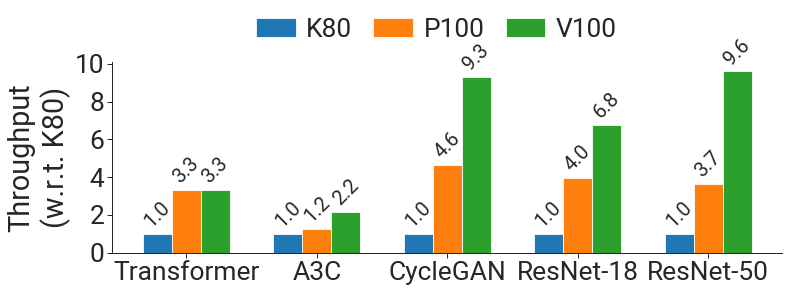

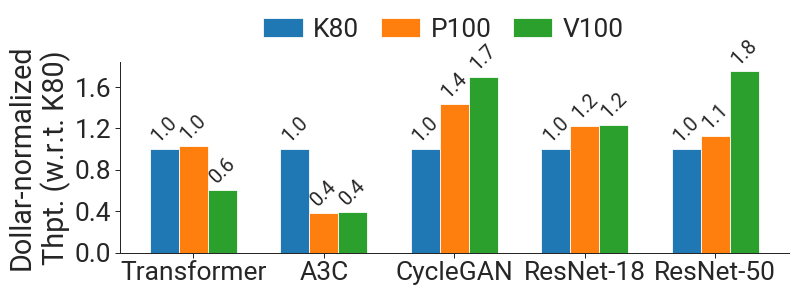

In [6]:
model_mapping = {
    'ResNet-18 (batch size 256)': 'ResNet-18',
    'ResNet-50 (batch size 128)': 'ResNet-50',
    'Transformer (batch size 256)': 'Transformer',
}
label_mapping = {
    'k80': 'K80',
    'p100': 'P100',
    'v100': 'V100',
}
plot_throughputs(models=['Transformer (batch size 256)',
                         'A3C', 'CycleGAN',
                         'ResNet-18 (batch size 256)',
                         'ResNet-50 (batch size 128)'],
                 model_mapping=model_mapping,
                 label_mapping=label_mapping,
                 output_filename="../graphs/gcp/normalized_throughput_per_cost/throughput.pdf")
plot_throughputs(models=['Transformer (batch size 256)',
                         'A3C',
                         'CycleGAN',
                         'ResNet-18 (batch size 256)',
                         'ResNet-50 (batch size 128)'],
                 model_mapping=model_mapping,
                 label_mapping=label_mapping,
                 normalized=True,
                 output_filename="../graphs/gcp/normalized_throughput_per_cost/normalized_throughput_per_cost.pdf")

# Print prices and plot normalized throughputs with time using AWS spot prices

In [7]:
def compute_and_print_prices(aws_prices):
    aws_instances = {
        "p2.xlarge": ("k80", 1),
        "p2.8xlarge": ("k80", 8),
        "p2.16xlarge": ("k80", 16),
        "p3.2xlarge": ("v100", 1),
        "p3.8xlarge": ("v100", 4),
        "p3.16xlarge": ("v100", 8),
    }

    times_to_process = {}
    print("=========================================================")
    for model in models:
        print("Model: %s" % model)
        print("=========================================================")
        times_to_process[model] = {}
        for worker_type in ["v100", "p100", "k80"]:
            if model in throughputs[worker_type]:
                # Time to perform training with 100,000 training samples.
                time_to_process = (
                    100000 / isolated_throughputs[worker_type][model]) / 3600
                times_to_process[model][worker_type] = time_to_process
                print("%s\t%.3f samples/sec\t%.3f hrs" % (
                    worker_type,
                    isolated_throughputs[worker_type][model],
                    time_to_process))

        print("\nCost on AWS")
        for aws_instance in aws_instances:
            (gpu_type, num_gpus) = aws_instances[aws_instance]
            [max_price, min_price] = aws_prices[aws_instance]
            per_gpu_max_price, per_gpu_min_price = \
                max_price / num_gpus, min_price / num_gpus
            print("\t%s\tUSD %.3f\tUSD %.3f" % (
                aws_instance,
                times_to_process[model][gpu_type] * per_gpu_min_price,
                times_to_process[model][gpu_type] * per_gpu_max_price))
        print("=========================================================")

In [9]:
compute_and_print_prices(utils.read_aws_prices("../logs/aws/cost/us-east-1"))

Model: A3C
v100	8.233 samples/sec	3.374 hrs
p100	4.755 samples/sec	5.842 hrs
k80	3.829 samples/sec	7.254 hrs

Cost on AWS
	p2.xlarge	USD 2.443	USD 6.529
	p2.8xlarge	USD 1.959	USD 6.529
	p2.16xlarge	USD 1.959	USD 6.529
	p3.2xlarge	USD 3.097	USD 4.133
	p3.8xlarge	USD 3.097	USD 3.107
	p3.16xlarge	USD 3.097	USD 3.097
Model: CycleGAN
v100	4.918 samples/sec	5.648 hrs
p100	2.447 samples/sec	11.351 hrs
k80	0.529 samples/sec	52.491 hrs

Cost on AWS
	p2.xlarge	USD 17.679	USD 47.242
	p2.8xlarge	USD 14.173	USD 47.242
	p2.16xlarge	USD 14.173	USD 47.242
	p3.2xlarge	USD 5.185	USD 6.919
	p3.8xlarge	USD 5.185	USD 5.200
	p3.16xlarge	USD 5.185	USD 5.185
Model: LM (batch size 10)
v100	143.361 samples/sec	0.194 hrs
p100	103.564 samples/sec	0.268 hrs
k80	29.665 samples/sec	0.936 hrs

Cost on AWS
	p2.xlarge	USD 0.315	USD 0.843
	p2.8xlarge	USD 0.253	USD 0.843
	p2.16xlarge	USD 0.253	USD 0.843
	p3.2xlarge	USD 0.178	USD 0.237
	p3.8xlarge	USD 0.178	USD 0.178
	p3.16xlarge	USD 0.178	USD 0.178
Model: LM (batch size 

In [10]:
from datetime import datetime
import os

def plot_normalized_throughput_by_price(per_instance_type_spot_prices,
                                        aws_instances,
                                        output_directory=None):
    all_timestamps = []
    for instance_type in per_instance_type_spot_prices:
        all_timestamps.extend(
            [x['Timestamp']
             for x in per_instance_type_spot_prices[instance_type]])
    all_timestamps.sort()
    first_timestamp = all_timestamps[0]
    
    for model in models:
        print(model)
    
        plt.figure(figsize=(10, 3))
        ax = plt.subplot2grid((1, 1), (0, 0), colspan=1)

        for instance_type in per_instance_type_spot_prices:

            availability_zones = [x['AvailabilityZone']
                                  for x in per_instance_type_spot_prices[instance_type]]
            if instance_type not in aws_instances:
                continue
            (gpu_type, num_gpus) = aws_instances[instance_type]
            
            throughput = isolated_throughputs[gpu_type][model]

            for availability_zone in list(set(availability_zones))[:2]:
                per_instance_type_spot_prices[instance_type].sort(
                    key=lambda x: x['Timestamp'])
                spot_prices = [float(x['SpotPrice']) / num_gpus
                               for x in per_instance_type_spot_prices[instance_type]
                               if x['AvailabilityZone'] == availability_zone]
                prices = [(throughput * 3600) / (x * 1000.0) for x in spot_prices]
                timestamps = [
                    (x['Timestamp']
                     - first_timestamp).total_seconds() / (3600 * 24)
                    for x in per_instance_type_spot_prices[instance_type]
                    if x['AvailabilityZone'] == availability_zone]
                ax.plot(timestamps, prices, marker='|',
                        label="%s (%s)" % (instance_type, availability_zone))

        ax.set_ylabel("Normalized\nThroughput")
        ax.set_xlabel("Time (days)")
        ax.set_ylim([0, None])
        ax.set_xlim([0, None])
        sns.despine()

        leg = plt.figlegend(ncol=2, frameon=False, labelspacing=0.25,
                            columnspacing=0.8, handlelength=1.5,
                            loc='upper center')

        bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)
        y_offset = 0.43
        bb.y0 += y_offset
        bb.y1 += y_offset
        leg.set_bbox_to_anchor(bb, transform=ax.transAxes)
        
        if output_directory is not None:
            file_name = model.replace(
                " (batch size ", "_batch_size=").replace(
                ")", "").lower() + ".pdf"
            output_filename = os.path.join(output_directory,
                                           file_name)
            with PdfPages(output_filename) as pdf:
                pdf.savefig(bbox_inches='tight')

        plt.show()

A3C


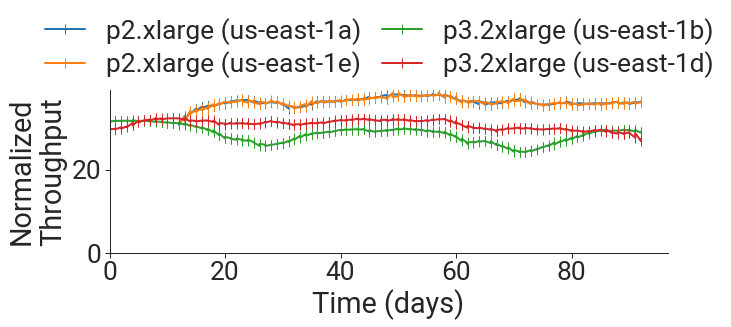

CycleGAN


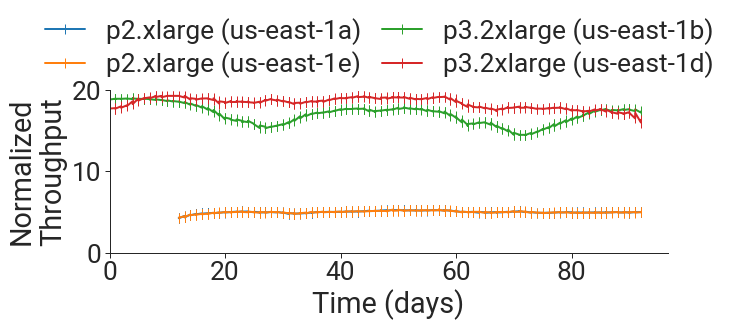

LM (batch size 10)


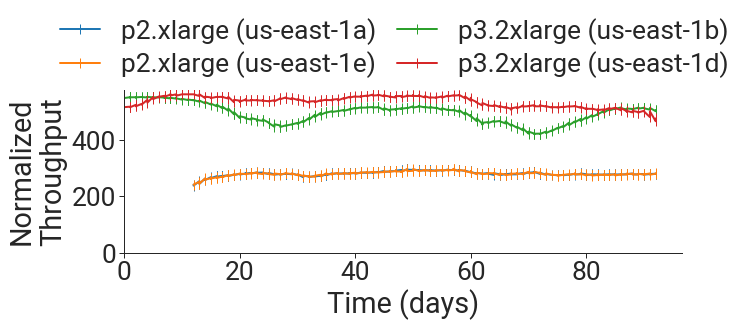

LM (batch size 20)


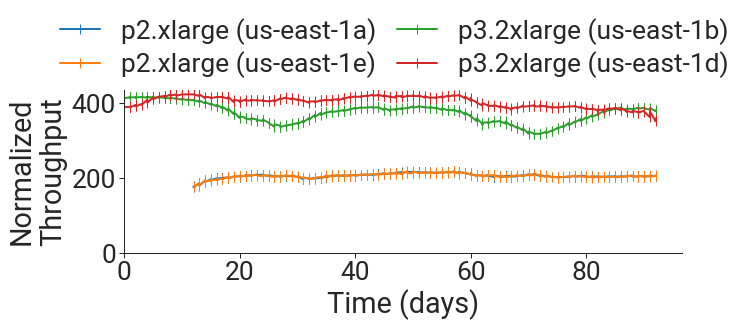

LM (batch size 40)


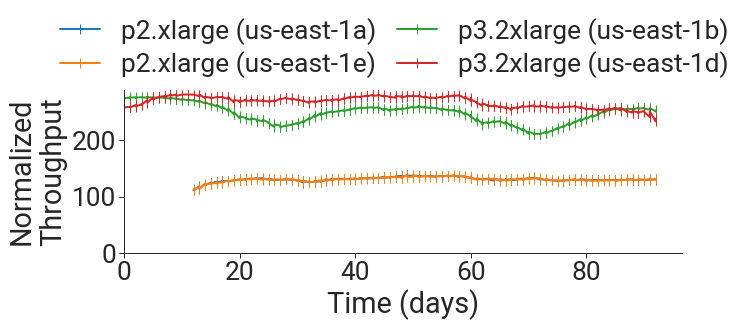

LM (batch size 5)


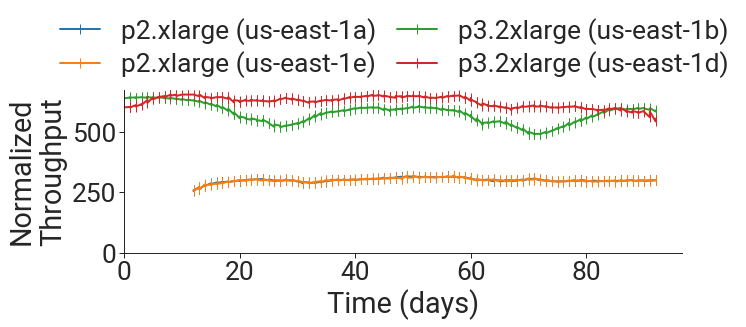

LM (batch size 80)


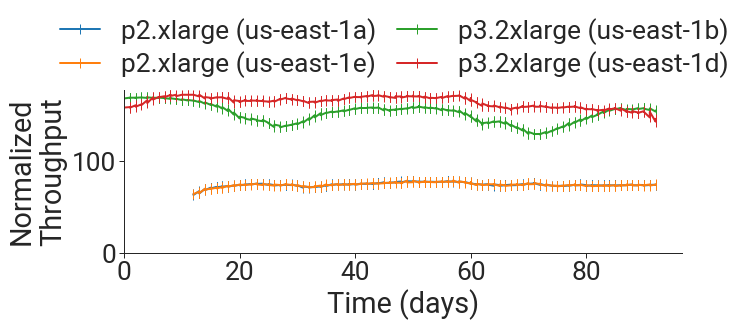

Recommendation (batch size 1024)


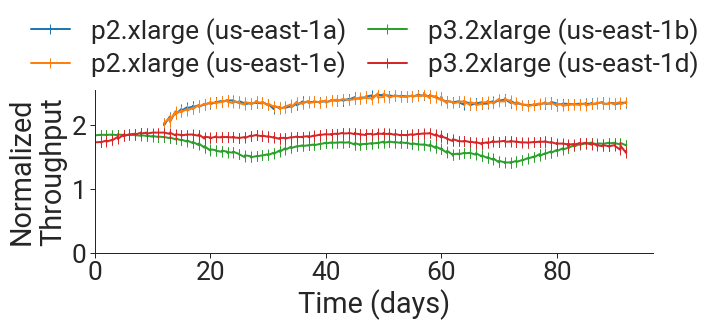

Recommendation (batch size 2048)


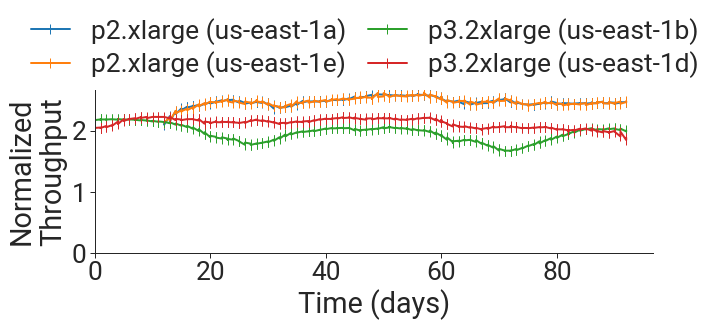

Recommendation (batch size 4096)


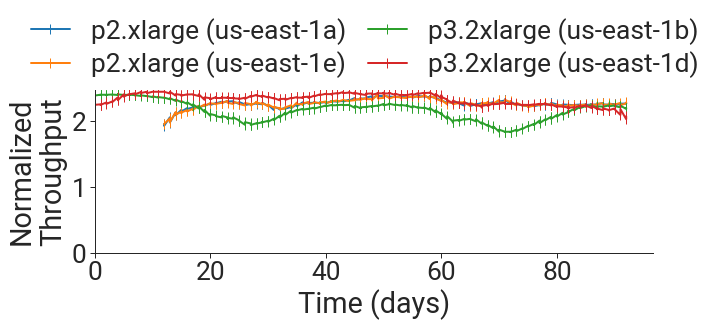

Recommendation (batch size 512)


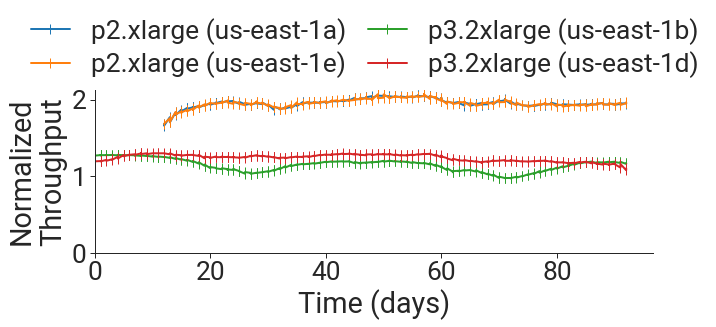

Recommendation (batch size 8192)


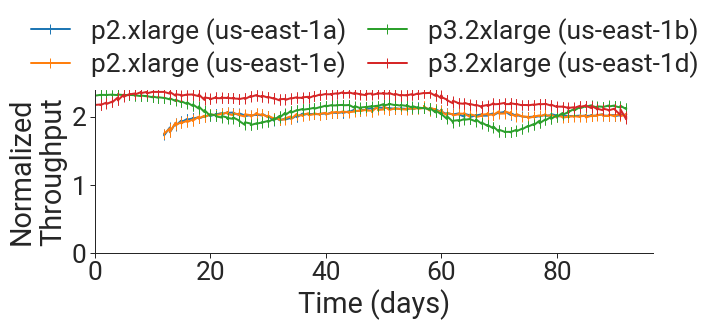

ResNet-18 (batch size 128)


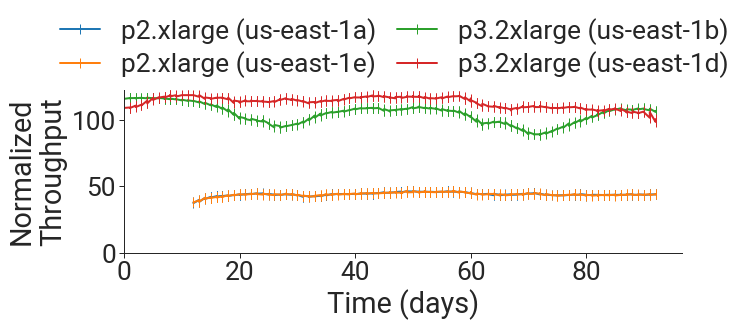

ResNet-18 (batch size 16)


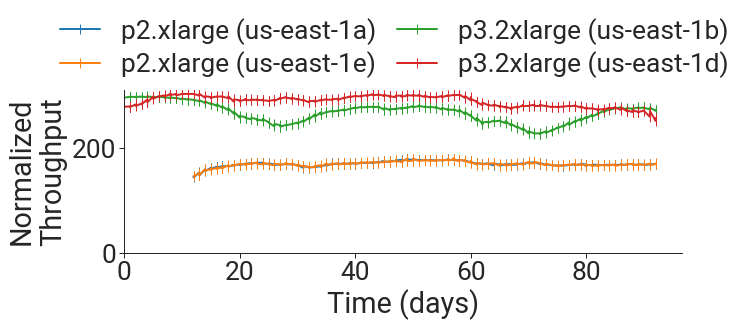

ResNet-18 (batch size 256)


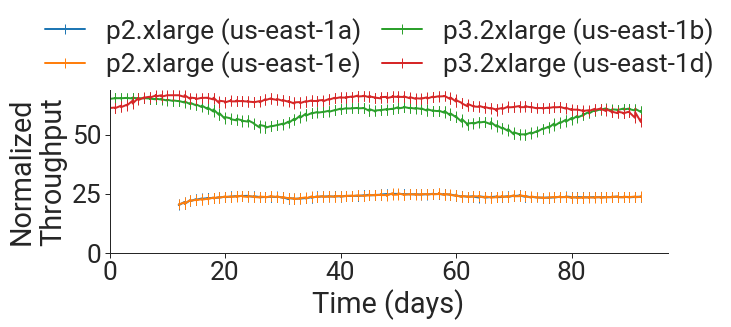

ResNet-18 (batch size 32)


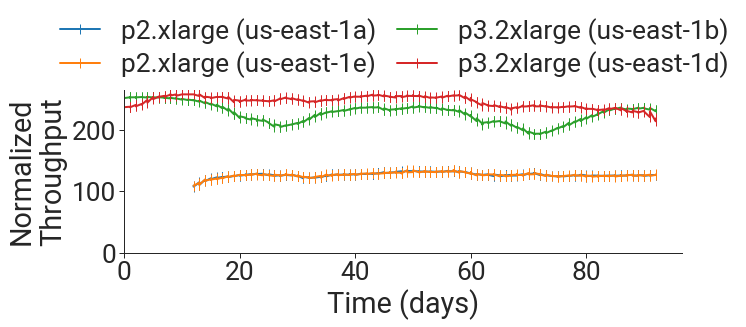

ResNet-18 (batch size 64)


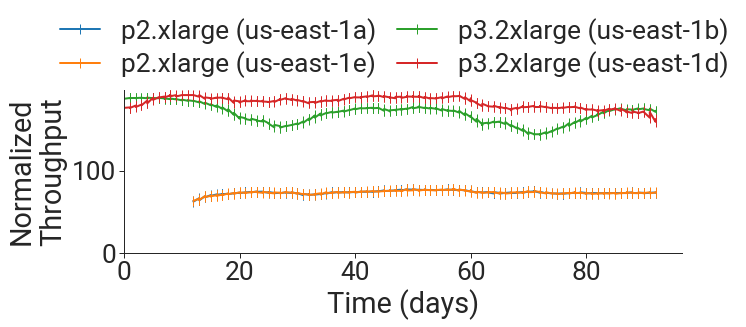

ResNet-50 (batch size 128)


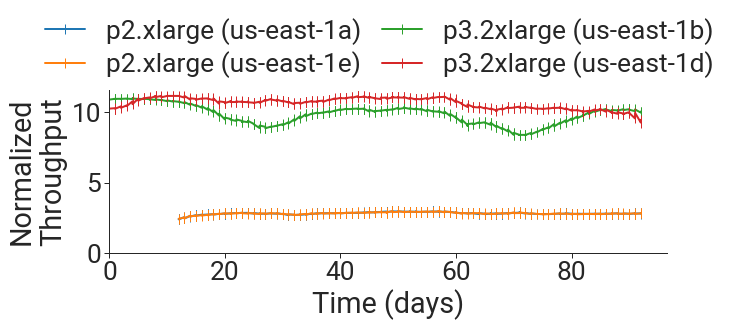

ResNet-50 (batch size 16)


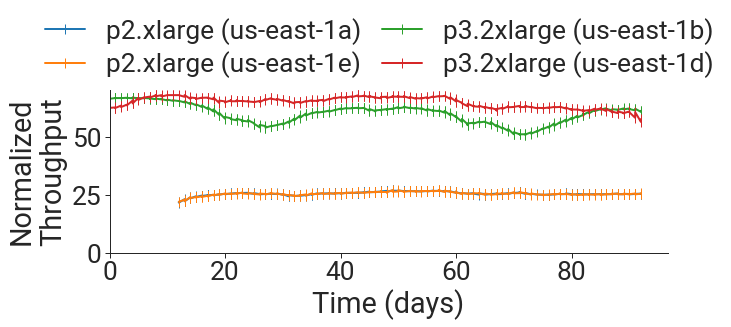

ResNet-50 (batch size 32)


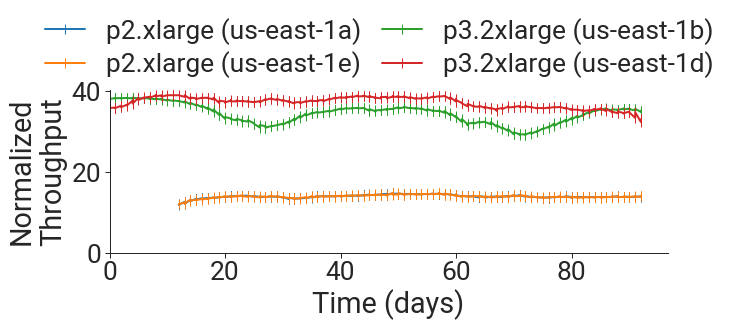

ResNet-50 (batch size 64)


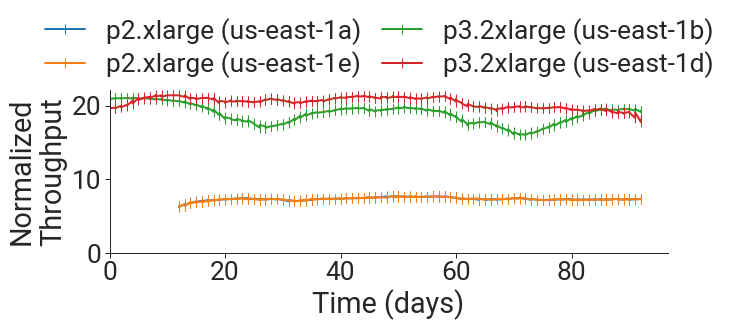

Transformer (batch size 128)


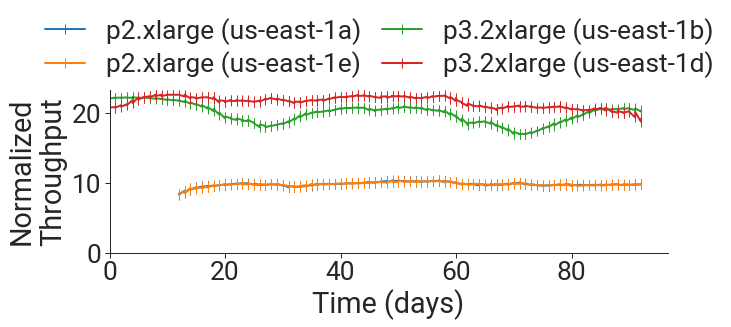

Transformer (batch size 16)


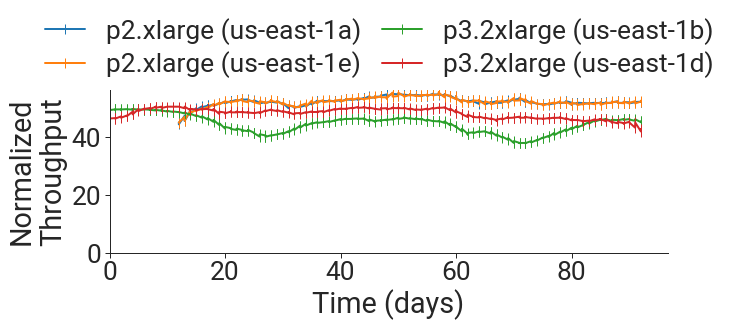

Transformer (batch size 256)


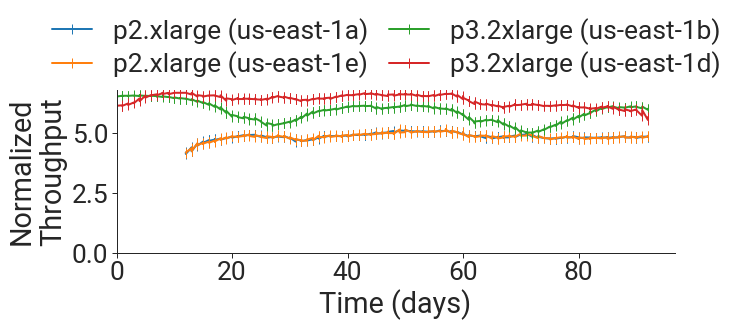

Transformer (batch size 32)


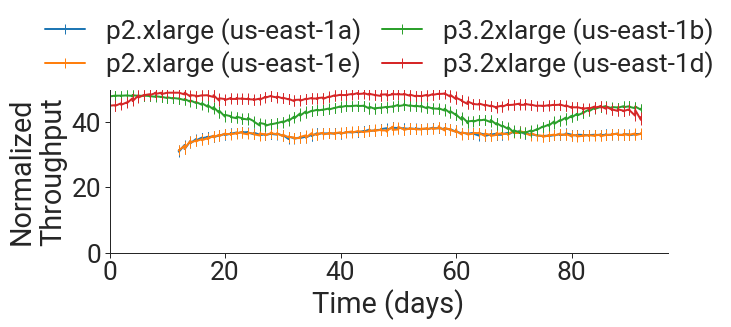

Transformer (batch size 64)


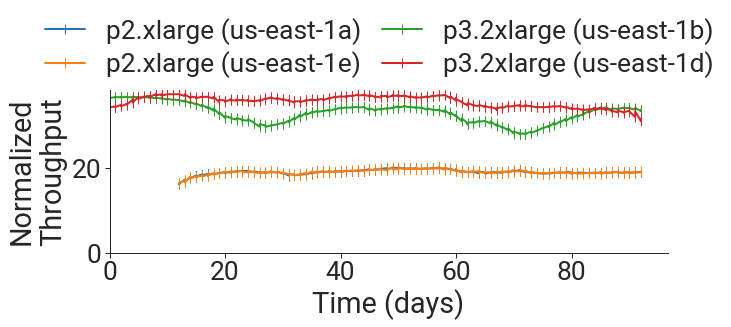

In [11]:
aws_instances = {
    "p2.xlarge": ("k80", 1),
    "p3.2xlarge": ("v100", 1),
}
plot_normalized_throughput_by_price(utils.read_aws_prices("../logs/aws/cost/us-east-1", summary=False),
                                    aws_instances,
                                    output_directory="../graphs/aws/normalized_throughput_per_cost/us_east_1")